In [7]:
!pip install delta-spark==3.2.0 -q
import pyspark
from delta import *
from pyspark.sql.functions import *

# Create a SparkSession with Delta Lake extensions
# The '.config(...)' lines are crucial for enabling Delta Lake's features
builder = pyspark.sql.SparkSession.builder.appName("DeltaTutorial") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

# Get or create the SparkSession
spark = configure_spark_with_delta_pip(builder).getOrCreate()

print("Spark and Delta Lake are ready!")
spark

Spark and Delta Lake are ready!


In [11]:
from pyspark.sql import functions as F, types as T
from datetime import datetime


# Inline data definitions
trip_schema = T.StructType([
    T.StructField("trip_id",    T.IntegerType()),
    T.StructField("rider_id",   T.StringType()),
    T.StructField("driver_id",  T.StringType()),
    T.StructField("city",       T.StringType()),
    T.StructField("distance_km",T.DoubleType()),
    T.StructField("fare",       T.DoubleType()),
    T.StructField("tip",        T.DoubleType()),
    T.StructField("ts",         T.TimestampType())
])

driver_schema = T.StructType([
    T.StructField("driver_id",   T.StringType()),
    T.StructField("driver_name", T.StringType()),
    T.StructField("rating",      T.DoubleType()),
    T.StructField("vehicle",     T.StringType())
])

trips_rows = [
    (1001, "R001", "D010", "Bengaluru", 12.4, 320.0, 20.0,
     datetime(2025, 8, 8,  8,  5,  0)),
    (1002, "R002", "D011", "Hyderabad",  6.2, 150.0, 10.0,
     datetime(2025, 8, 8,  8, 15,  0)),
    (1003, "R003", "D012", "Pune",       3.5,  90.0,  0.0,
     datetime(2025, 8, 8,  8, 20,  0)),
    (1004, "R001", "D010", "Bengaluru", 18.9, 480.0, 25.0,
     datetime(2025, 8, 8,  8, 45,  0)),
    (1005, "R004", "D013", "Chennai",   10.0, 260.0, 15.0,
     datetime(2025, 8, 8,  9,  5,  0)),
    (1006, "R005", "D012", "Pune",       2.2,  70.0,  0.0,
     datetime(2025, 8, 8,  9, 10,  0))
]

drivers_rows = [
    ("D010", "Anil",  4.8, "WagonR"),
    ("D011", "Sana",  4.6, "i20"),
    ("D012", "Rakesh",4.4, "Swift"),
    ("D013", "Meera", 4.9, "Ciaz")
]

trips_df   = spark.createDataFrame(trips_rows,   schema=trip_schema)\
                  .withColumn("ts", F.to_timestamp("ts"))
drivers_df = spark.createDataFrame(drivers_rows, schema=driver_schema)

BASE         = "/tmp/delta/ride_hailing"
TRIPS_PATH   = f"{BASE}/trips"
DRIVERS_PATH = f"{BASE}/drivers"

trips_df.write.format("delta").mode("overwrite").save(TRIPS_PATH)
drivers_df.write.format("delta").mode("overwrite").save(DRIVERS_PATH)
print("Seeded:")
print(" Trips   ->", TRIPS_PATH)
print(" Drivers ->", DRIVERS_PATH)

Seeded:
 Trips   -> /tmp/delta/ride_hailing/trips
 Drivers -> /tmp/delta/ride_hailing/drivers


# 1) Managed vs Unmanaged Tables

In [102]:
spark.sql("""create table if not exists trips_managed using delta as select*from delta.`/tmp/delta/ride_hailing/trips`;""")
spark.sql("""create table if not exists drivers_ext using delta location '/tmp/delta/ride_hailing/drivers';""")

DataFrame[]

in the below cell the location of managed table(trips_managed) is in file/content /spark-warehouse/managed_tables and the external table(driver_ext)is stored in absoulte file path

In [103]:
spark.sql("describe detail trips_managed").show()
spark.sql("describe detail drivers_ext").show()

+------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+----------------+-----------------+--------+-----------+----------+----------------+----------------+--------------------+
|format|                  id|                name|description|            location|           createdAt|        lastModified|partitionColumns|clusteringColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|       tableFeatures|
+------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+----------------+-----------------+--------+-----------+----------+----------------+----------------+--------------------+
| delta|38ae0c95-227a-409...|spark_catalog.def...|       NULL|file:/content/spa...|2025-08-14 11:33:...|2025-08-14 11:33:...|              []|               []|       2|       5121|        {}|               1|               2|[appendOnly, inva...|
+------+

# 2) Read & Explore

In [53]:
trips = spark.read.format("delta").load(TRIPS_PATH)
drivers = spark.read.format("delta").load(DRIVERS_PATH)

trips.printSchema()
drivers.printSchema()

trips.withColumn("total_amount", F.col("fare") + F.col("tip")) \
     .orderBy(F.desc("total_amount")) \
     .show(5)

root
 |-- trip_id: integer (nullable = true)
 |-- rider_id: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- city: string (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- fare: double (nullable = true)
 |-- tip: double (nullable = true)
 |-- ts: timestamp (nullable = true)

root
 |-- driver_id: string (nullable = true)
 |-- driver_name: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- vehicle: string (nullable = true)

+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|total_amount|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|       505.0|
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|       340.0|
|   1005|    R004|     D013|  Chennai|      

# 3) Update (Business Rule)

In [54]:
from delta.tables import DeltaTable
delta_trips = DeltaTable.forPath(spark, TRIPS_PATH)

print("Before Update:")
delta_trips.toDF().filter("city = 'Bengaluru' AND distance_km > 15").show()

delta_trips.update(
    condition="city = 'Bengaluru' AND distance_km > 15",set={"tip": F.col("tip") + 5}
)

print("After Update:")
delta_trips.toDF().filter("city = 'Bengaluru' AND distance_km > 15").show()


Before Update:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+

After Update:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|30.0|2025-08-08 08:45:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



#4) Delete (Data Quality)

In [55]:
delta_trips.delete("fare <= 0 OR distance_km <= 0")
print("Remaining row count:", delta_trips.toDF().count())


Remaining row count: 6


# 5) Merge (Upsert New Batch)

In [57]:
new_data = [
    (1004,"R001","D010","Bengaluru", 18.9, 500.0,  30.0,datetime(2025,8,8,8,45,0)),
    (1007,"R006","D011","Hyderabad",  5.0, 120.0,  15.0, datetime(2025,8,8,9,20,0)),
]
new_df = spark.createDataFrame(new_data, schema=trip_schema)
delta_trips.alias("target").merge(new_df.alias("source"),"target.trip_id=source.trip_id").whenMatchedUpdateAll().whenNotMatchedInsertAll().execute()
delta_trips.toDF().show()

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|500.0|30.0|2025-08-08 08:45:00|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|
|   1006|    R005|     D012|     Pune|        2.2| 70.0| 0.0|2025-08-08 09:10:00|
|   1007|    R006|     D011|Hyderabad|        5.0|120.0|15.0|2025-08-08 09:20:00|
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|
|   1003|    R003|     D012|     Pune|        3.5| 90.0| 0.0|2025-08-08 08:20:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



# 6) Gold View (Join & KPIs)

In [60]:
gold_df=delta_trips.toDF().join(drivers,"driver_id")
gold_view=gold_df.withColumn("total_amount",F.col("fare")+F.col("tip")).select("trip_id","city","driver_name","rating","distance_km","total_amount","ts")
gold_view.show()

+-------+---------+-----------+------+-----------+------------+-------------------+
|trip_id|     city|driver_name|rating|distance_km|total_amount|                 ts|
+-------+---------+-----------+------+-----------+------------+-------------------+
|   1004|Bengaluru|       Anil|   4.8|       18.9|       530.0|2025-08-08 08:45:00|
|   1005|  Chennai|      Meera|   4.9|       10.0|       275.0|2025-08-08 09:05:00|
|   1006|     Pune|     Rakesh|   4.4|        2.2|        70.0|2025-08-08 09:10:00|
|   1007|Hyderabad|       Sana|   4.6|        5.0|       135.0|2025-08-08 09:20:00|
|   1001|Bengaluru|       Anil|   4.8|       12.4|       340.0|2025-08-08 08:05:00|
|   1002|Hyderabad|       Sana|   4.6|        6.2|       160.0|2025-08-08 08:15:00|
|   1003|     Pune|     Rakesh|   4.4|        3.5|        90.0|2025-08-08 08:20:00|
+-------+---------+-----------+------+-----------+------------+-------------------+



In [65]:
from pyspark.sql.functions import sum as _sum,avg
city_wise=gold_view.groupBy("city").agg(_sum("total_amount").alias("total_amount"),avg("rating").alias("average_driver_rating"))
city_wise.show()
driver_wise=gold_view.groupBy("driver_name").agg(count("*").alias("total_trips"),_sum("total_amount").alias("total_amount"))
driver_wise.orderBy(desc("total_trips")).show(3)

+---------+------------+---------------------+
|     city|total_amount|average_driver_rating|
+---------+------------+---------------------+
|  Chennai|       275.0|                  4.9|
|     Pune|       160.0|                  4.4|
|Bengaluru|       870.0|                  4.8|
|Hyderabad|       295.0|                  4.6|
+---------+------------+---------------------+

+-----------+-----------+------------+
|driver_name|total_trips|total_amount|
+-----------+-----------+------------+
|     Rakesh|          2|       160.0|
|       Sana|          2|       295.0|
|       Anil|          2|       870.0|
+-----------+-----------+------------+
only showing top 3 rows



#7) Time Travel & History

In [66]:
delta_trips.history().show(truncate=False)

+-------+-----------------------+------+--------+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+--------+---------+-----------+--------------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+-----------------------------------+
|versio

In [71]:
old=spark.read.format("delta").option("versionAsOf",0).load(TRIPS_PATH)
old.head()
delta_trips.toDF().head()
print("count of old:",old.count())
print("count of new:",delta_trips.toDF().count())

count of old: 6
count of new: 7


# 8) Partitioned Rewrite (Performance)

In [72]:
partitoned_path=f"{BASE}/trips_partitioned"
delta_trips.toDF().write.format("delta").mode("overwrite").partitionBy("city").save(partitoned_path)


In [80]:
import os
import time
files=os.listdir(partitoned_path)
print(files)
start_time = time.time()
bengaluru_df = spark.read.format("delta").load(partitoned_path).filter("city = 'Bengaluru'")
bengaluru_df.show()
end_time = time.time()

print(f"Read time for city='Bengaluru': {end_time - start_time:.4f} seconds")

start_time = time.time()
bengaluru_unpart = spark.read.format("delta").load(TRIPS_PATH ).filter("city = 'Bengaluru'").count()
end_time = time.time()
print(f"Unpartitioned read time: {end_time - start_time:.4f} seconds (Rows: {bengaluru_unpart})")

['_delta_log', 'city=Chennai', 'city=Hyderabad', 'city=Bengaluru', 'city=Pune']
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
|   1004|    R001|     D010|Bengaluru|       18.9|500.0|30.0|2025-08-08 08:45:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+

Read time for city='Bengaluru': 1.1957 seconds
Unpartitioned read time: 1.8264 seconds (Rows: 2)


# 9) Incremental Load Simulation

In [85]:
batch_data = [
    (1008,"R007","D013","Mumbai", 12.0, 300.0,  20.0,datetime(2025,8,8,8,33,0)),
    (1009,"R008","D010","Mumbai", 15.0, 400.0,  25.0, datetime(2025,8,8,9,55,0)),
]
update_df=spark.createDataFrame(batch_data,schema=trip_schema)
update_df.write.format("delta").mode("append").save(TRIPS_PATH)

recheck=spark.read.format("delta").load(TRIPS_PATH)
city_wise_recheck=recheck.groupBy("city").agg(F.sum("fare").alias("total_revenue"))
city_wise_recheck.show()

+---------+-------------+
|     city|total_revenue|
+---------+-------------+
|  Chennai|        260.0|
|   Mumbai|       2100.0|
|     Pune|        160.0|
|Bengaluru|        820.0|
|Hyderabad|        270.0|
+---------+-------------+



#10) Simple Streaming (File Stream → Console)

In [86]:
from threading import Thread
import time


stream_query = (
    spark.readStream.format("delta").load(TRIPS_PATH)
        .writeStream
        .format("memory")
        .queryName("trip_stream")
        .outputMode("append")
        .trigger(processingTime='3 seconds')
        .start()
)


time.sleep(5)


extra_batch = [
    (1012,"R020","D011","Mumbai", 7.0, 180.0, 15.0, datetime(2025,8,8,8,10,0))
]
extra_df = spark.createDataFrame(extra_batch, schema=trip_schema)
extra_df.write.format("delta").mode("append").save(TRIPS_PATH)


time.sleep(5)

spark.sql("SELECT * FROM trip_stream ORDER BY ts DESC").show()


stream_query.stop()


+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1009|    R008|     D010|   Mumbai|       15.0|400.0|25.0|2025-08-08 09:55:00|
|   1009|    R008|     D010|   Mumbai|       15.0|400.0|25.0|2025-08-08 09:55:00|
|   1009|    R008|     D010|   Mumbai|       15.0|400.0|25.0|2025-08-08 09:55:00|
|   1007|    R006|     D011|Hyderabad|        5.0|120.0|15.0|2025-08-08 09:20:00|
|   1006|    R005|     D012|     Pune|        2.2| 70.0| 0.0|2025-08-08 09:10:00|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|
|   1004|    R001|     D010|Bengaluru|       18.9|500.0|30.0|2025-08-08 08:45:00|
|   1008|    R007|     D013|   Mumbai|       12.0|300.0|20.0|2025-08-08 08:33:00|
|   1008|    R007|     D013|   Mumbai|       12.0|300.0|20.0|2025-08-08 08:33:00|
|   1008|    R00

# 11) Visualization

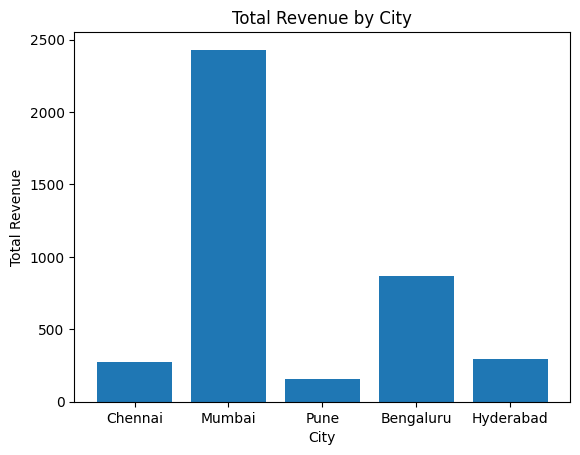

In [88]:
city_w=city_wise.toPandas()
import matplotlib.pyplot as plt
plt.bar(city_w["city"],city_w['total_amount'])
plt.xlabel("City")
plt.ylabel("Total Revenue")
plt.title("Total Revenue by City")
plt.show()

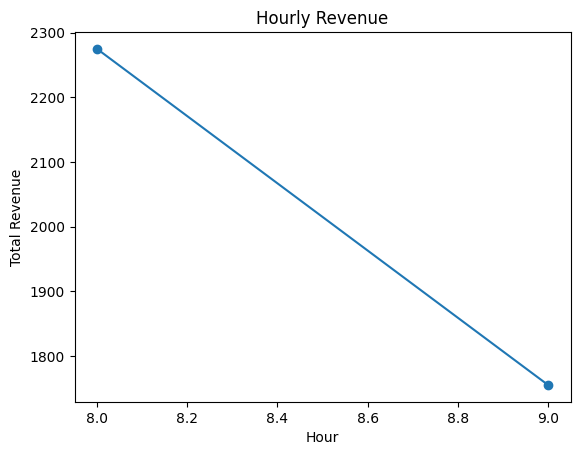

In [96]:

hourly_revenue_pd = gold_view.withColumn("hour", F.hour("ts")).groupBy("hour").agg(F.sum("total_amount").alias("total_revenue")).toPandas()
plt.plot(hourly_revenue_pd["hour"], hourly_revenue_pd["total_revenue"], marker='o')
plt.xlabel("Hour")
plt.ylabel("Total Revenue")
plt.title("Hourly Revenue")
plt.show()

## 12) MANAGED vs UNMANAGED CLEANUP

In [104]:
spark.sql("DROP TABLE trips_managed")
spark.sql("DROP TABLE drivers_ext")

DataFrame[]

In [105]:
import os
print("Managed path exists after drop ", os.path.exists("/content/spark-warehouse/trips_managed"))
print("Unmanaged path exists after drop ", os.path.exists(DRIVERS_PATH))

Managed path exists after drop  False
Unmanaged path exists after drop  True


# 13) CONSTRAINT / QUALITY CHECK

In [112]:
bad_data = [(1011,"R010","D010","Bengaluru", 10.0, 300.0, -5.0, datetime(2025,8,10,4,27,0))]
bad_df = spark.createDataFrame(bad_data, schema=trip_schema)
if (bad_df.filter('tip<0')):
  print("incorrect tip and its not appending to the file:")
else:
  print("its a valid data")
  bad_df.write.format("delta").mode("append").save(TRIPS_PATH)

incorrect tip and its not appending to the file:


# 14) CONVERT PARQUET → DELTA


In [113]:
PARQUET_PATH = f"{BASE}/trips_parquet"

subset_df = spark.read.format("delta").load(TRIPS_PATH).limit(3)
subset_df.write.mode("overwrite").parquet(PARQUET_PATH)

print("Parquet files created at:", PARQUET_PATH)
!ls -R {PARQUET_PATH}

Parquet files created at: /tmp/delta/ride_hailing/trips_parquet
/tmp/delta/ride_hailing/trips_parquet:
part-00000-63af47f5-fe03-4bdc-a8c2-6c7fb479675b-c000.snappy.parquet  _SUCCESS


In [114]:
spark.sql(f"convert to delta parquet.`{PARQUET_PATH}`")

DataFrame[]

In [116]:
print("\nAfter Conversion to Delta:")
spark.read.format("delta").load(PARQUET_PATH).show()



delta_parquet = DeltaTable.forPath(spark, PARQUET_PATH)

# New batch with:
# - one existing trip_id (update fare)
# - one new trip_id (insert)
merge_data = [
    (1001,"R001","D010","Bengaluru", 12.4, 350.0,  25.0, datetime(2025,9,9,9,45,0)),
    (2001,"R050","D013","Chennai",    8.0, 200.0,  10.0, datetime(2025,9,9,10,45,0))
]
merge_df = spark.createDataFrame(merge_data, schema=trip_schema)

delta_parquet.alias("t").merge(
    merge_df.alias("n"),
    "t.trip_id = n.trip_id"
).whenMatchedUpdateAll() \
 .whenNotMatchedInsertAll() \
 .execute()

print("\nAfter MERGE:")
delta_parquet.toDF().show()


print("\nHistory of Converted Delta Table:")
delta_parquet.history().show()

print("\nVersion 0 (Before MERGE):")
spark.read.format("delta").option("versionAsOf", 0).load(PARQUET_PATH).show()

print("\nLatest Version (After MERGE):")
spark.read.format("delta").load(PARQUET_PATH).show()


After Conversion to Delta:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|
|   1003|    R003|     D012|     Pune|        3.5| 90.0| 0.0|2025-08-08 08:20:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+


After MERGE:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1001|    R001|     D010|Bengaluru|       12.4|350.0|25.0|2025-09-09 09:45:00|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0

#  15) Bonus KPI Dashboard (Notebook Display)

 Total Revenue: 4030.00


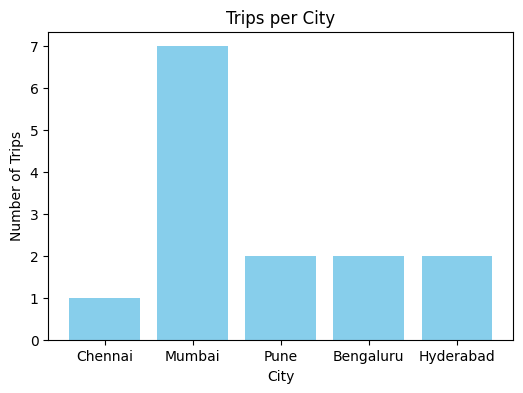

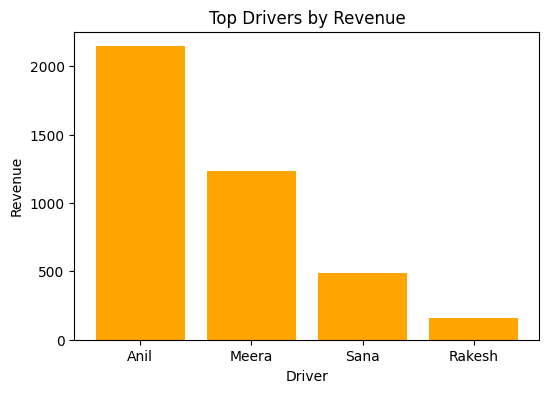

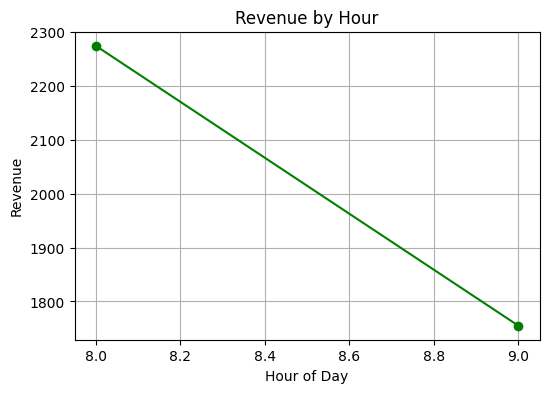

In [117]:
import matplotlib.pyplot as plt
import pandas as pd

trips_df_latest = spark.read.format("delta").load(TRIPS_PATH)
drivers_df_latest = spark.read.format("delta").load(DRIVERS_PATH)

gold_df = trips_df_latest.join(drivers_df_latest, "driver_id") .withColumn("total_amount", F.col("fare") + F.col("tip")) .select("trip_id", "city", "driver_name", "rating", "distance_km", "total_amount", "ts")


total_revenue = gold_df.agg(F.sum("total_amount")).collect()[0][0]
print(f" Total Revenue: {total_revenue:.2f}")

trips_per_city_pd = gold_df.groupBy("city").count().toPandas()
plt.figure(figsize=(6,4))
plt.bar(trips_per_city_pd["city"], trips_per_city_pd["count"], color="skyblue")
plt.title("Trips per City")
plt.xlabel("City")
plt.ylabel("Number of Trips")
plt.show()


top_drivers_pd = gold_df.groupBy("driver_name") .agg(F.sum("total_amount").alias("total_revenue")) .orderBy(F.desc("total_revenue")).toPandas()
plt.figure(figsize=(6,4))
plt.bar(top_drivers_pd["driver_name"], top_drivers_pd["total_revenue"], color="orange")
plt.title("Top Drivers by Revenue")
plt.xlabel("Driver")
plt.ylabel("Revenue")
plt.show()


revenue_by_hour_pd = gold_df.withColumn("hour", F.hour("ts")) .groupBy("hour") .agg(F.sum("total_amount").alias("total_revenue")) .orderBy("hour") .toPandas()
plt.figure(figsize=(6,4))
plt.plot(revenue_by_hour_pd["hour"], revenue_by_hour_pd["total_revenue"], marker='o', color="green")
plt.title("Revenue by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()
